<h1 style="text-align:center; font-size:2.5rem">Fake News classification using NLP techniques</h1>

# Problem Statement

Imagine you are working for a social media company. The company is concerned with the growing amount of fake news circulatng on it's platform. They have assigned you to investigate how fake news can be recognized and create a method of identifying it. 

Let's work through this problem together, first by exploring and cleaning the data and then working to classify fake vs factual news stories. We'll also create some plots of our outputs and discuss how we would communicate our findings to stakeholders.

# Importing all necessary libraries

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# Importing the dataset

In [2]:
data = pd.read_csv("fake_news_data.csv")

In [3]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


We don't have any null values. Therefore, we can skip null value handling.

# Counting the categories

We want to make sure the dataset has more or less the same number of records for all categories. We plot the count of classifications

In [5]:
# The standard plot is 6.4 x 4.8. We want to increase its size to 8 x 6
plt.rcParams['figure.figsize'] = [8, 6]
default_plot_color = "#00bfbf"

Text(0.5, 1.0, 'Count of Article Classifications (fake/factual)')

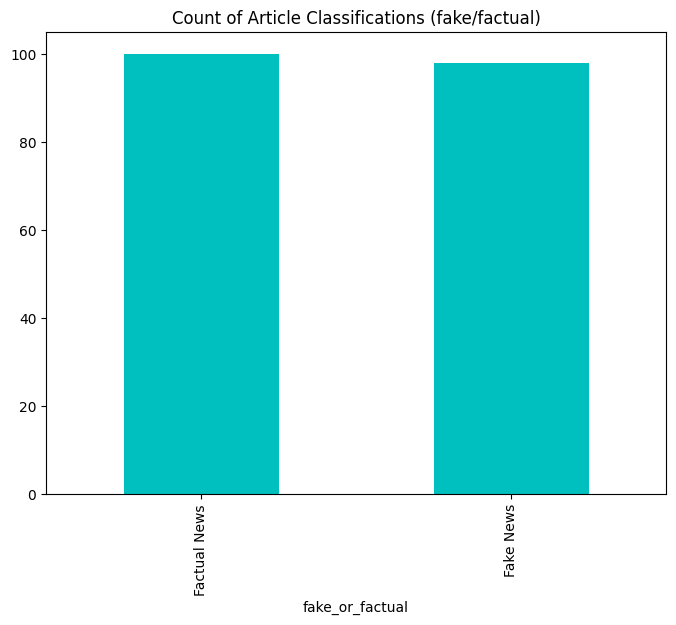

In [6]:
data["fake_or_factual"].value_counts().plot(kind="bar", color="#00bfbf")
plt.title("Count of Article Classifications (fake/factual)")

These values are in ball-park range (i.e. similar number of records per category). So we should be good to go.

# Parts Of Speech Tagging

Extracting the POS tags from the fake news and factual news separately to identify what differences could be there in the POS tags. We will use SpaCy for this process.

In [7]:
en_nlp = spacy.load("en_core_web_sm")

In [8]:
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

In [9]:
fake_spacydocs = list(en_nlp.pipe(fake_news["text"]))
fact_spacydocs = list(en_nlp.pipe(fact_news["text"]))

In [10]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [11]:
fake_tags_df = []
fact_tags_df = []
columns = ['token', 'ner_tag', 'pos_tag']

In [12]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tags_df.append(tags)
fake_tags_df = pd.concat(fake_tags_df)

In [13]:
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tags_df.append(tags)
fact_tags_df = pd.concat(fact_tags_df)

In [14]:
fake_tags_df.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [15]:
pos_counts_fake = fake_tags_df.groupby(["token", "pos_tag"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [16]:
pos_counts_fact = fact_tags_df.groupby(["token", "pos_tag"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


We haven't cleaned this data yet, hence we are seeing stop words and punctuation marks on top of the list.

In [17]:
fake_tags_df.groupby("pos_tag")["token"].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     7799
PROPN    5337
VERB     5281
ADP      4533
PUNCT    4301
DET      3560
PRON     3119
ADJ      2710
AUX      2155
ADV      1672
Name: token, dtype: int64

In [18]:
fact_tags_df.groupby("pos_tag")["token"].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     7288
PROPN    5187
VERB     4516
PUNCT    4436
ADP      4353
DET      3463
ADJ      2540
AUX      1838
PRON     1804
PART     1219
Name: token, dtype: int64

Both fake and factual datasets have nouns, proper nouns and verbs as the top parts of speech tags.

In [19]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [20]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


Factual news has more of government-related nouns while fake news has more of general words, i.e., people are on top of the list and refers to people in general.

We then want to check what the differences in their named entities are.

# Named Entities

In [21]:
top_entities_fake = fake_tags_df[fake_tags_df["ner_tag"] != ""]\
    .groupby(["token", "ner_tag"])\
    .size()\
    .reset_index(name="counts")\
    .sort_values(by="counts", ascending=False)

In [22]:
top_entities_fact = fact_tags_df[fact_tags_df["ner_tag"] != ""]\
    .groupby(["token", "ner_tag"])\
    .size()\
    .reset_index(name="counts")\
    .sort_values(by="counts", ascending=False)

In [23]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most common named entities in fake news')]

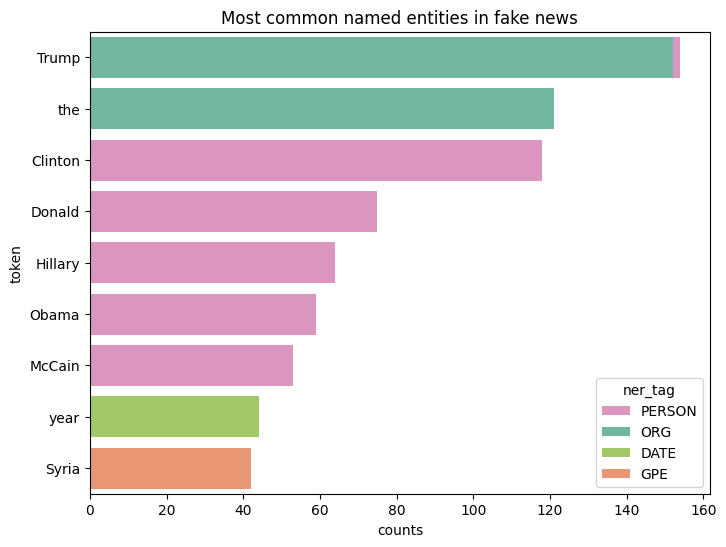

In [24]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title="Most common named entities in fake news")

[Text(0.5, 1.0, 'Most common named entities in factual news')]

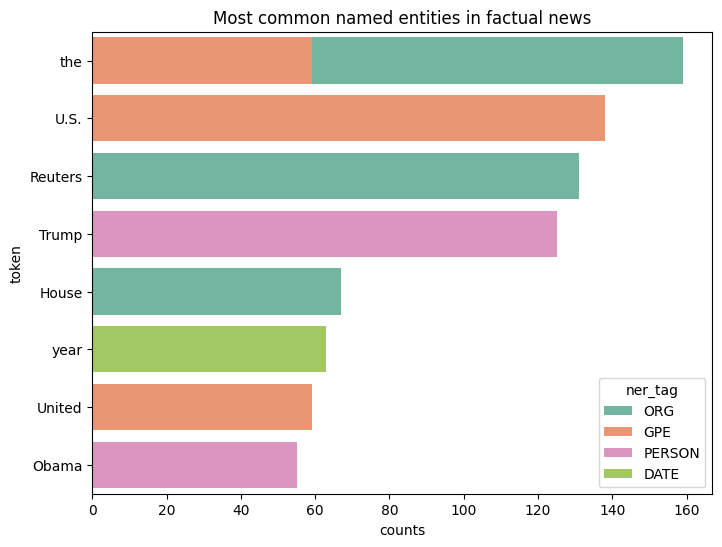

In [25]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient='h',
    dodge=False
).set(title="Most common named entities in factual news")

We have obtained the following insights:

1. Factual news may have more to do with organizations while fake news may have more to do with people (according to the classifier)

# Text pre-processing

1. Converting to lower-case
2. Removing the stop words and punctuation
3. Tokenize the text
4. Stemming/Lemmatization of the text. Lemmatization provides more context than stemming hence I prefer it.

In [26]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


One observation in this dataset is that factual news starts with the reporting place and news agency. Hence, we could say that anything without these two could be fake news just by looking at the dataset.

Some factual news snippets may not contain this in some other datasets. Or more likely some fake news snippets may contain random places and news agencies. Hence, we can choose not to include this portion in pre-processing.

Furthermore, these two can influence the model further and impact the outcomes. Hence, we have chosen to remove this portion by scanning the following regular expression: 

`^[^-]*-\s`.

which translates to:

` is not (contains any number of non-hyphenated characters followed by a hyphen followed by a whitespace) `

- `^`: is not
- `[^-]`: square brackets indicate group of words. So this indicates any character that is not a hyphen.
- `*`: any number of. For example, `[a-z]*` indicates any number of lowerspace characters.
- `\s`: whitespace

In [27]:
data["text_without_prefixes"] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1)

In [28]:
data["lower"] = data["text_without_prefixes"].str.lower()

In [29]:
en_stopwords = stopwords.words("english")
data["no_stop"] = data["lower"].apply(lambda x: ' '.join(word for word in x.split() if word not in en_stopwords))

In [30]:
data["no_punct"] = data.apply(lambda x: re.sub(r"[^\w\s]", "", x["no_stop"]), axis=1)

In [31]:
data["tokenize"] = data["no_punct"].apply(lambda x: word_tokenize(x))

In [32]:
lemmatizer = WordNetLemmatizer()
data["lemmatize"] = data["tokenize"].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [33]:
# Indicating that this is the cleaned data
data["text_cleaned"] = data["lemmatize"]

In [34]:
data.head()

,title,text,date,fake_or_factual,text_without_prefixes,lower,no_stop,no_punct,tokenize,lemmatize,text_cleaned
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m...","[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,...","women make up over 50 percent of this country,...","women make 50 percent country, grossly underre...",women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said monday ...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon...","[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,...","[northern, ireland, political, party, rapidly,..."


In [35]:
tokens = sum(data["text_cleaned"], [])

In [36]:
unigrams = (pd.Series(nltk.ngrams(tokens, 1)).value_counts()).reset_index()
print(unigrams[:10])

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


/tmp/ipykernel_44087/467467709.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Unigrams after pre-processing')]

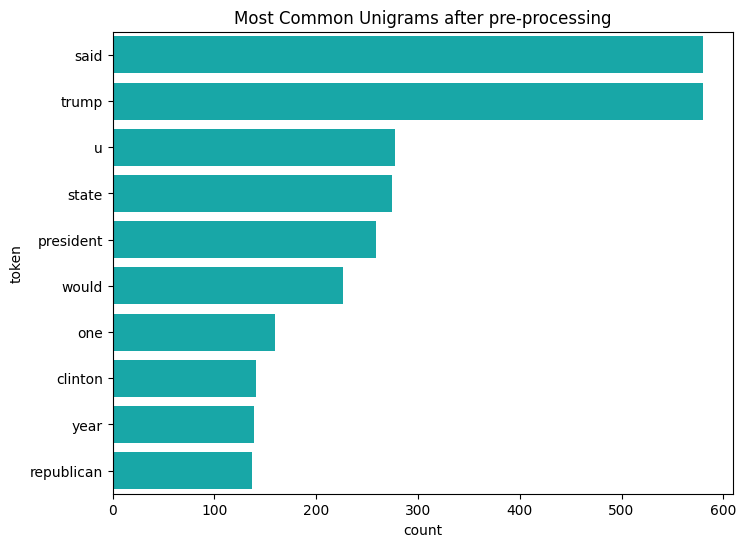

In [37]:
unigrams["token"] = unigrams["index"].apply(lambda x: x[0])

sns.barplot(
    x = "count",
    y = "token",
    data = unigrams[:10],
    orient = "h",
    palette = [default_plot_color],
    hue = "token"
).set(title="Most Common Unigrams after pre-processing")

In [38]:
bigrams = (pd.Series(nltk.ngrams(tokens, 2)).value_counts()).reset_index()
print(bigrams[:10])

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8  (trump, administration)     26
9         (official, said)     26


In [39]:
trigrams = (pd.Series(nltk.ngrams(tokens, 3)).value_counts()).reset_index()
print(trigrams[:10])

                           index  count
0     (president, donald, trump)     46
1     (president, barack, obama)     14
2              (new, york, time)     11
3       (white, house, official)     10
4           (food, stamp, fraud)     10
5         (u, president, donald)     10
6       (director, james, comey)      8
7         (fbi, director, james)      8
8  (national, security, adviser)      7
9        (high, school, student)      7


# Sentiment analysis

Does sentiment differ between news types? Does fake have more positive news than facts?

We will experiment with the vader sentiment package.

In [40]:
vader_sentiment = SentimentIntensityAnalyzer()

In [41]:
data["vader_sentiment_score"] = data["text"].apply(lambda x: vader_sentiment.polarity_scores(x)["compound"])

In [42]:
bins = [-1, -0.1, 0.1, 1]
names = ["negative", "neutral", "positive"]

In [43]:
data["vader_sentiment_label"] = pd.cut(data["vader_sentiment_score"], bins, labels=names)

In [44]:
data.head()

,title,text,date,fake_or_factual,text_without_prefixes,lower,no_stop,no_punct,tokenize,lemmatize,text_cleaned,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m...","[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,...","women make up over 50 percent of this country,...","women make 50 percent country, grossly underre...",women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said monday ...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon...","[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,...","[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

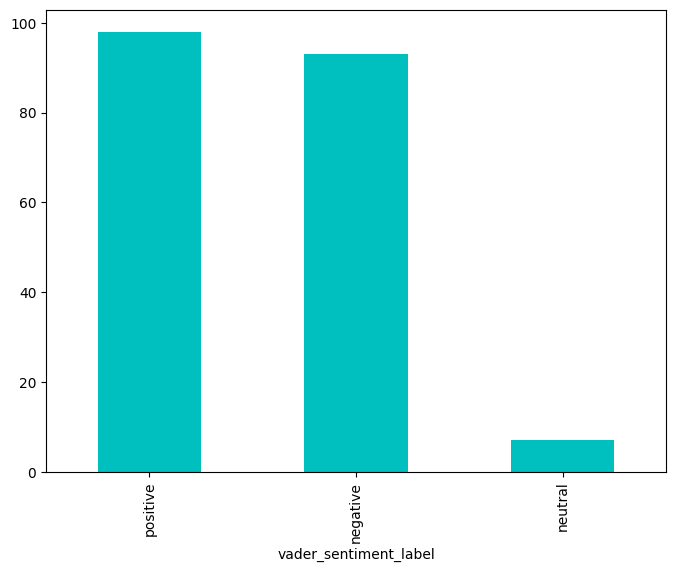

In [45]:
data["vader_sentiment_label"].value_counts().plot.bar(color=default_plot_color)

/tmp/ipykernel_44087/3298778351.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by news type')]

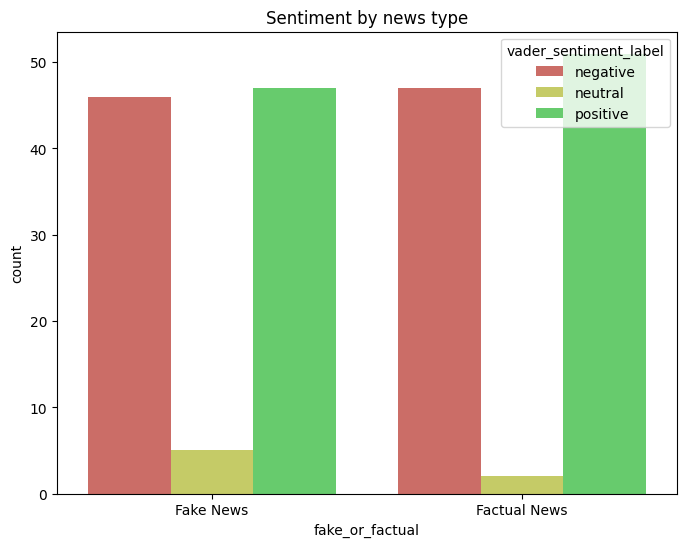

In [46]:
sns.countplot(
    x = "fake_or_factual",
    hue = "vader_sentiment_label",
    palette = sns.color_palette("hls"),
    data = data
    ).set(title="Sentiment by news type")

# Topic Modelling

Next, we will try to group news articles by their topics using Latent Dirichlet Allocation (LDA) and Latent Semantic Analysis (LSA)

In [47]:
fake_news_text = data[data["fake_or_factual"] == "Fake News"]["text_cleaned"].reset_index(drop=True)
fact_news_text = data[data["fake_or_factual"] == "Factual News"]["text_cleaned"].reset_index(drop=True)

In [48]:
dictionary_fake = corpora.Dictionary(fake_news_text)
dictionary_fact = corpora.Dictionary(fact_news_text)

In [49]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]
doc_term_fact = [dictionary_fact.doc2bow(text) for text in fact_news_text]

In [50]:
fake_values = []
fact_values = []
fake_models = []
fact_models = []

MIN_TOPICS = 2
MAX_TOPICS = 6

num_topics_fake = 1
num_topics_fact = 1
curr_value_fake = 0
curr_value_fact = 0

for n in range(MIN_TOPICS, MAX_TOPICS + 1):
    # for the fake dataset
    model_fake = gensim.models.LsiModel(
        corpus = doc_term_fake,
        id2word = dictionary_fake,
        num_topics = n
    )
    fake_models.append(model_fake)
    coherence_model_fake = CoherenceModel(
        model = model_fake,
        texts = fake_news_text,
        dictionary = dictionary_fake,
        coherence = 'c_v'
    )
    coherence_value = coherence_model_fake.get_coherence()
    fake_values.append(coherence_value)
    if coherence_value > curr_value_fake:
        num_topics_fake = n
        curr_value_fake = coherence_value
    # for the factual dataset
    model_fact = gensim.models.LsiModel(
        corpus = doc_term_fact,
        id2word = dictionary_fact,
        num_topics = n
    )
    fact_models.append(model_fact)
    coherence_model_fact = CoherenceModel(
        model = model_fact,
        texts = fact_news_text,
        dictionary = dictionary_fact,
        coherence = 'c_v'
    )
    coherence_value = coherence_model_fact.get_coherence()
    fact_values.append(coherence_value)
    if coherence_value > curr_value_fact:
        num_topics_fact = n
        curr_value_fact = coherence_value

In [51]:
num_topics_fake

2

In [52]:
num_topics_fact

2

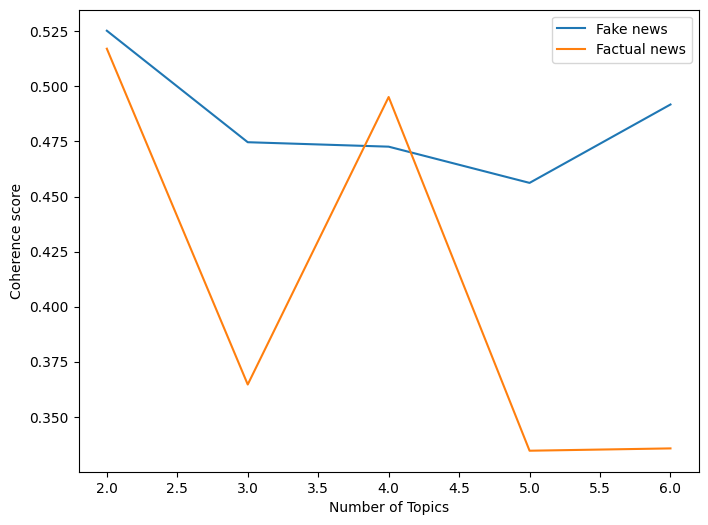

In [53]:
plt.plot(range(MIN_TOPICS, MAX_TOPICS+1), fake_values, label="Fake news")
plt.plot(range(MIN_TOPICS, MAX_TOPICS+1), fact_values, label="Factual news")
plt.legend(loc='best')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

In [54]:
lda_fake = gensim.models.LdaModel(
    corpus = doc_term_fake,
    id2word = dictionary_fake,
    num_topics = num_topics_fake
)
lda_fake.print_topics()

[(0,
  '0.010*"trump" + 0.005*"clinton" + 0.004*"president" + 0.004*"said" + 0.004*"would" + 0.003*"u" + 0.003*"one" + 0.003*"republican" + 0.003*"time" + 0.003*"hillary"'),
 (1,
  '0.012*"trump" + 0.005*"said" + 0.005*"state" + 0.004*"president" + 0.003*"u" + 0.003*"would" + 0.003*"one" + 0.003*"time" + 0.003*"donald" + 0.003*"people"')]

In [55]:
lda_fact = gensim.models.LdaModel(
    corpus = doc_term_fact,
    id2word = dictionary_fact,
    num_topics = num_topics_fact
)
lda_fact.print_topics()

[(0,
  '0.018*"said" + 0.009*"trump" + 0.007*"u" + 0.007*"state" + 0.006*"president" + 0.005*"would" + 0.004*"government" + 0.003*"year" + 0.003*"house" + 0.003*"also"'),
 (1,
  '0.017*"said" + 0.012*"trump" + 0.007*"u" + 0.005*"state" + 0.005*"would" + 0.004*"president" + 0.003*"court" + 0.003*"house" + 0.003*"united" + 0.003*"could"')]

In [56]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [57]:
# create tfidf representation for both fake and factual datasets
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
corpus_tfidf_fact = tfidf_corpus(doc_term_fact)

In [58]:
fake_values = []
fact_values = []
fake_models = []
fact_models = []

MIN_TOPICS = 2
MAX_TOPICS = 6

num_topics_fake = 1
num_topics_fact = 1
curr_value_fake = 0
curr_value_fact = 0

for n in range(MIN_TOPICS, MAX_TOPICS + 1):
    # for the fake dataset
    model_fake = gensim.models.LsiModel(
        corpus = corpus_tfidf_fake,
        id2word = dictionary_fake,
        num_topics = n
    )
    fake_models.append(model_fake)
    coherence_model_fake = CoherenceModel(
        model = model_fake,
        texts = fake_news_text,
        dictionary = dictionary_fake,
        coherence = 'c_v'
    )
    coherence_value = coherence_model_fake.get_coherence()
    fake_values.append(coherence_value)
    if coherence_value > curr_value_fake:
        num_topics_fake = n
        curr_value_fake = coherence_value
    # for the factual dataset
    model_fact = gensim.models.LsiModel(
        corpus = corpus_tfidf_fact,
        id2word = dictionary_fact,
        num_topics = n
    )
    fact_models.append(model_fact)
    coherence_model_fact = CoherenceModel(
        model = model_fact,
        texts = fact_news_text,
        dictionary = dictionary_fact,
        coherence = 'c_v'
    )
    coherence_value = coherence_model_fact.get_coherence()
    fact_values.append(coherence_value)
    if coherence_value > curr_value_fact:
        num_topics_fact = n
        curr_value_fact = coherence_value

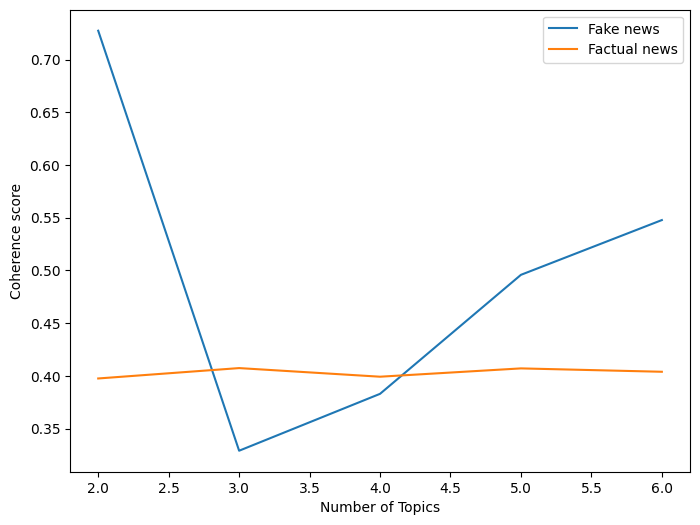

In [59]:
plt.plot(range(MIN_TOPICS, MAX_TOPICS+1), fake_values, label="Fake news")
plt.plot(range(MIN_TOPICS, MAX_TOPICS+1), fact_values, label="Factual news")
plt.legend(loc='best')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

In [60]:
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=num_topics_fake)
lsa_fake.print_topics()

[(0,
  '0.188*"trump" + 0.134*"clinton" + 0.093*"obama" + 0.093*"hillary" + 0.089*"president" + 0.086*"woman" + 0.077*"republican" + 0.077*"flynn" + 0.077*"party" + 0.074*"candidate"'),
 (1,
  '-0.326*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"')]

In [61]:
lsa_fact = LsiModel(corpus_tfidf_fact, id2word=dictionary_fact, num_topics=num_topics_fact)
lsa_fact.print_topics()

[(0,
  '-0.198*"trump" + -0.126*"court" + -0.113*"korea" + -0.100*"bill" + -0.097*"state" + -0.091*"putin" + -0.089*"order" + -0.086*"ban" + -0.086*"russia" + -0.084*"israel"'),
 (1,
  '-0.333*"korea" + -0.226*"south" + 0.185*"court" + -0.176*"north" + -0.172*"china" + -0.147*"japanese" + 0.125*"ban" + -0.122*"abe" + 0.121*"order" + -0.120*"korean"'),
 (2,
  '0.255*"putin" + -0.251*"korea" + 0.220*"syria" + 0.189*"israel" + -0.152*"south" + 0.137*"israeli" + -0.128*"north" + 0.122*"syrian" + -0.119*"court" + 0.119*"strike"')]

# Classifying fake vs factual news using classical machine learning models

In this example, we will use Logistic Regression and Support Vector Machines.

In [62]:
data.head()

,title,text,date,fake_or_factual,text_without_prefixes,lower,no_stop,no_punct,tokenize,lemmatize,text_cleaned,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m...","[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,...","women make up over 50 percent of this country,...","women make 50 percent country, grossly underre...",women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said monday ...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon...","[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,...","[northern, ireland, political, party, rapidly,...",0.8590,positive


In [63]:
x = [','.join(map(str, l)) for l in data['text_cleaned']]
y = data['fake_or_factual']

In [64]:
countvec = CountVectorizer()

In [65]:
countvec_fit = countvec.fit_transform(x)

In [66]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [67]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

In [68]:
lr = LogisticRegression()
lr1 = lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

In [69]:
accuracy_score(y_test, y_pred_lr)

0.85

In [70]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.82      0.94      0.87        33
   Fake News       0.91      0.74      0.82        27

    accuracy                           0.85        60
   macro avg       0.86      0.84      0.84        60
weighted avg       0.86      0.85      0.85        60



In [71]:
svm = SGDClassifier()
svm_fit = svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

In [72]:
accuracy_score(y_test, y_pred_svm)

0.8833333333333333

In [73]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.88      0.91      0.90        33
   Fake News       0.88      0.85      0.87        27

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



## Using a TF-IDF Vectorizer instead of a CountVectorizer

i.e., using TF-IDF instead of bag of words

In [74]:
tfidfvec = TfidfVectorizer()

In [75]:
tfidfvec_fit = tfidfvec.fit_transform(x)

In [76]:
word_matrix = pd.DataFrame(tfidfvec_fit.toarray(), columns=tfidfvec.get_feature_names_out())

In [77]:
word_matrix

,01,03,05,08441,10,100,1000,10000,1000000000000000,1002,...,zimbabwean,zimdars,zimmerman,zina,zionism,zoe,zone,zoom,zouka,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.070631,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
x_train, x_test, y_train, y_test = train_test_split(word_matrix, y, test_size=0.3)

In [79]:
lr = LogisticRegression()
lr1 = lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

In [80]:
accuracy_score(y_test, y_pred_lr)

0.8

In [81]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.73      0.89      0.80        27
   Fake News       0.89      0.73      0.80        33

    accuracy                           0.80        60
   macro avg       0.81      0.81      0.80        60
weighted avg       0.82      0.80      0.80        60



In [82]:
svm = SGDClassifier()
svm_fit = svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

In [83]:
accuracy_score(y_test, y_pred_svm)

0.9

In [84]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.82      1.00      0.90        27
   Fake News       1.00      0.82      0.90        33

    accuracy                           0.90        60
   macro avg       0.91      0.91      0.90        60
weighted avg       0.92      0.90      0.90        60

